In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd /content/drive/MyDrive/

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [ ]:
#Lazyloading
class LazyLoadDataset(Dataset):
    def __init__(self,path,train=True,transform=None):
        self.transform = transform
        path = path+('train/' if train else 'test/')
        self.pathX = path+'X/'
        self.pathY = path+'Y/'
        
        self.data = os.listdir(self.pathX)
        
    def __getitem__(self,idx):
        f = self.data[idx]
        img0 = cv2.imread(self.pathX+ f+'/rgb/0.png')
        img1 = cv2.imread(self.pathX+ f+'/rgb/1.png')
        img2 = cv2.imread(self.pathX+ f+'/rgb/2.png')
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        depth = np.load(self.pathX + f + '/depth.npy')/ 1000
        
        field_id = pkl.load(open(self.pathX + f + '/field_id.pkl','rb' ))
        
        Y = np.load(self.pathY + f + '.npy')#*1000
        
        return (img0, img1, img2, depth, field_id),Y

    
    def __len__(self):
        return len(self.data)

In [ ]:
dataset=  LazyLoadDataset('./lazydata/')
(img0,img1,img2,depth,field_id),Y = dataset[1]

In [ ]:
img0.shape, img1.shape,img2.shape,depth.shape,field_id,Y.shape

((224, 224, 3), (224, 224, 3), (224, 224, 3), (3, 224, 224), '422', (12,))

<function matplotlib.pyplot.show(close=None, block=None)>

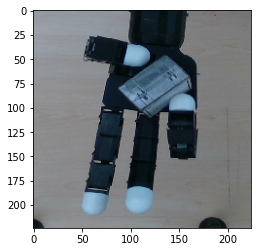

In [ ]:
plt.imshow(img0[:,:,::-1])
#plt.imshow(depth[0])
plt.show

In [ ]:
#TestLazyloading
class LazyLoadTestDataset(Dataset):
    def __init__(self,path,train=False,transform=None):
        self.transform = transform
        path = path+'test/'
        self.pathX = path+'X/'
        
        self.data = os.listdir(self.pathX)
        
    def __getitem__(self,idx):
        f = self.data[idx]
        img0 = cv2.imread(self.pathX+ f+'/rgb/0.png')
        img1 = cv2.imread(self.pathX+ f+'/rgb/1.png')
        img2 = cv2.imread(self.pathX+ f+'/rgb/2.png')
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        depth = np.load(self.pathX + f + '/depth.npy')
        
        field_id = pkl.load(open(self.pathX + f + '/field_id.pkl','rb' ))
               
        return (img0, img1, img2, depth, field_id)

    
    def __len__(self):
        return len(self.data)

In [ ]:
#loss function. not use entropy
loss_fn = nn.MSELoss()

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X,y) in enumerate(dataloader):
        X=X[3]
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        #change to float for matching type
        loss = loss_fn(pred,y.float())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss)
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print( f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]"  )

In [ ]:
#various choices for batch_size from 2,8,16,64 etc.
batch_size=2
train_dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

In [ ]:
#CNN demo model 
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),


            nn.Flatten(),
            nn.Linear(50176,512),
            nn.ReLU(),
            nn.Linear(512, 12),
        )

    def forward(self, xb):
        return self.network(xb)

# function to count number of parameters
def get_n_params(model):
    # return number of parameters in model
    return sum(param.numel() for param in model.parameters())

In [ ]:
#debug process to check dataloader size
size = len(train_dataloader.dataset)
s=len(train_dataloader)
size,s

(3396, 1698)

In [ ]:
#my detailed debug process to determine each layer
conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

maxpool= nn.MaxPool2d(2,2)
flatten=nn.Flatten()

relu=nn.ReLU()

fc1 = nn.Linear(16 * 112 * 112, 1024)
fc2 = nn.Linear(1024, 512)
fc3 = nn.Linear(1024, 512)
fc4 = nn.Linear(512, 128)
fc2 = nn.Linear(128, 12)

i1=torch.Tensor(2,3,224,224)
i2=relu(conv1(i1))
i3=relu(conv2(i2))
i3=maxpool(i3)
i4=relu(conv3(i3))
i5=relu(conv4(i4))
i5=maxpool(i5)
i6=relu(conv5(i5))
i7=relu(conv6(i6))
i7=maxpool(i7)
#i1.shape,i2.shape
i7=flatten(i7)
i7.shape

torch.Size([2, 200704])

In [ ]:
# Training settings 

model_cnn = CNN() # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(),lr = 0.001)  # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

Number of parameters: 25720364


In [ ]:
#my debug process to find correct data type and size for training model
for batch, (X,y) in enumerate(train_dataloader):
    X, y = X[3].to(device), y.to(device)
    print(type(X),X.shape) #<class 'torch.Tensor'> torch.Size([1, 3, 224, 224])
    #
    break
    # pred = model(X)
    # loss = loss_fn(pred,y)
    
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    
    # if batch % 100 == 0:
    #     loss, current = loss.item(), batch*len(X)
    #     print( f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]"  )

<class 'torch.Tensor'> torch.Size([2, 3, 224, 224])


In [ ]:
model = CNN() # CNN model demo
model.to(device)

CNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=512, bias=True)
    (11): ReLU()
    (12): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [ ]:
model(X)

tensor([[-0.0706, -0.0180, -0.0011,  0.0068,  0.0296, -0.0860, -0.0521, -0.0096,
         -0.0011, -0.0375,  0.0392, -0.0027],
        [-0.0674, -0.0293,  0.0111,  0.0012,  0.0414, -0.0789, -0.0549, -0.0110,
          0.0033, -0.0244,  0.0331,  0.0078]], grad_fn=<AddmmBackward0>)

In [ ]:
#change epochs from 1 to 10 to more
epochs = 1
for t in range(epochs):
    print(f"Epoch{t+1}\n----------------------------")
    train(train_dataloader,model, loss_fn, optimizer)
    #test(test_dataloader,model,loss_fn)
print('Done!')

In [ ]:
#output
test_dataset = LazyLoadTestDataset('./lazydata/')
test_dataloader = DataLoader(test_dataset,batch_size=batch_size*2,shuffle=True)


In [ ]:
outfile = 'submissionDepth/225.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']
preds = []
file_ids=[]

test_dataset = LazyLoadTestDataset('./lazydata/',False)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=True)
model_cnn.eval()
#use test dataloading for output
for i, X in enumerate(test_dataloader):
    file_ids.append(X[4])
    #remember to keep the same transform as training modl
    rgb_data = X[3].to(device)
    output = model_cnn(rgb_data)
    preds.append(output[0].cpu().detach().numpy())

df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))